<a href="https://colab.research.google.com/github/DhanashriPatil11/AI_CAPTCHA_Recognition/blob/main/AI_CAPTCHA_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install captcha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
import os
import random
import string
import numpy as np
from captcha.image import ImageCaptcha
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Reproducibility (best-effort)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Config
CHARSET = string.digits + string.ascii_lowercase  # 0-9 + a-z -> 36 classes
CAPTCHA_LENGTH = 5 # eg a7c4b
IMG_W = 160
IMG_H = 60
IMG_CHANNELS = 1

TRAIN_SIZE = 2000   # increase for better accuracy (e.g., 10000+)
VAL_SIZE = 400
BATCH_SIZE = 64
EPOCHS = 15
DATA_DIR = 'captcha_data'
os.makedirs(DATA_DIR, exist_ok=True)

# %%
# Cell 2: Helper functions to generate CAPTCHA strings and images

image_generator = ImageCaptcha(width=IMG_W, height=IMG_H)

In [ ]:
def random_captcha_text(charset=CHARSET, length=CAPTCHA_LENGTH):
    return ''.join(random.choices(charset, k=length))

In [ ]:
def generate_captcha_image(text):
    # returns a grayscale numpy array of shape (H, W)
    img = image_generator.generate_image(text)
    img = img.convert('L')  # grayscale
    arr = np.array(img)
    return arr

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

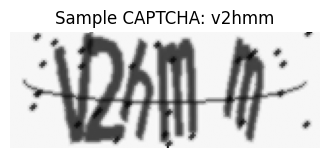

In [ ]:
# Quick visual sanity check
sample_text = random_captcha_text()
sample_img = generate_captcha_image(sample_text)
plt.figure(figsize=(4,2))
plt.title(f'Sample CAPTCHA: {sample_text}')
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
# %%
# Cell 3: Create dataset (images and labels) — this stores arrays in memory for simplicity


In [ ]:
def create_dataset(n_samples, out_dir=None):
    X = np.zeros((n_samples, IMG_H, IMG_W, 1), dtype=np.float32)
    y = np.zeros((n_samples, CAPTCHA_LENGTH), dtype=object)
    for i in range(n_samples):
        txt = random_captcha_text()
        img = generate_captcha_image(txt)
        # normalize and resize (images already correct size from generator)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)
        X[i] = img
        y[i, :] = list(txt)
        if out_dir:
            # optional: save images to disk
            filename = os.path.join(out_dir, f'{txt}_{i}.png')
            Image.fromarray((img.squeeze()*255).astype('uint8')).save(filename)
    return X, y

In [ ]:
print('Generating training set...')
X_train, y_train = create_dataset(TRAIN_SIZE)
print('Generating validation set...')
X_val, y_val = create_dataset(VAL_SIZE)

print('Shapes:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Generating training set...
Generating validation set...
Shapes: (2000, 60, 160, 1) (2000, 5) (400, 60, 160, 1) (400, 5)


In [ ]:
# %%
# Cell 4: Encode labels to one-hot vectors (list of arrays — one per character position)
char_to_idx = {c: i for i, c in enumerate(CHARSET)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

In [ ]:
# Convert object array of characters to integer indices per position
def encode_labels(y):
    # y shape: (N, CAPTCHA_LENGTH) of characters
    N = y.shape[0]
    encoded = np.zeros((N, CAPTCHA_LENGTH, len(CHARSET)), dtype=np.uint8)
    for i in range(N):
        for pos in range(CAPTCHA_LENGTH):
            ch = y[i, pos]
            encoded[i, pos, char_to_idx[ch]] = 1
    return encoded

In [ ]:
Y_train = encode_labels(y_train)
Y_val = encode_labels(y_val)

In [ ]:
# For Keras fit, we provide a list of arrays (one per output head)
y_train_list = [Y_train[:, i, :] for i in range(CAPTCHA_LENGTH)]
y_val_list = [Y_val[:, i, :] for i in range(CAPTCHA_LENGTH)]

print('Prepared one-hot labels. Example:', y_train[0], '\nOne-hot shape per head:', y_train_list[0].shape)


Prepared one-hot labels. Example: ['o' 'w' '3' 'f' '1'] 
One-hot shape per head: (2000, 36)


In [ ]:
# %%
# Cell 5: Define the CNN model (shared backbone, multiple softmax heads)

def build_model(input_shape=(IMG_H, IMG_W, 1), num_chars=CAPTCHA_LENGTH, num_classes=len(CHARSET)):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = []
    for i in range(num_chars):
        outputs.append(Dense(num_classes, activation='softmax', name=f'char_{i}')(x))

    model = Model(inputs=inp, outputs=outputs)
    return model

In [ ]:
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] * CAPTCHA_LENGTH)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 160,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 60, 160,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 160,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 80,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 30, 80,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 80,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 15, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 40,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 40,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 20,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 17920)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17920)     │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  9,175,552 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_0 (Dense)      │ (None, 36)        │     18,468 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_1 (Dense)      │ (None, 36)        │     18,468 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_2 (Dense)      │ (None, 36)        │     18,468 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_3 (Dense)      │ (None, 36)        │     18,468 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_4 (Dense)      │ (None, 36)        │     18,468 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,361,460 (35.71 MB)

 Trainable params: 9,361,012 (35.71 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# %%
# Cell 6: Training
checkpoint_path = 'captcha_cnn_best.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train_list,
    validation_data=(X_val, y_val_list),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - char_0_accuracy: 0.0212 - char_0_loss: 6.5148 - char_1_accuracy: 0.0249 - char_1_loss: 6.6325 - char_2_accuracy: 0.0312 - char_2_loss: 5.9789 - char_3_accuracy: 0.0324 - char_3_loss: 5.9770 - char_4_accuracy: 0.0218 - char_4_loss: 5.9440 - loss: 31.0511
Epoch 1: val_loss improved from inf to 63.01439, saving model to captcha_cnn_best.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - char_0_accuracy: 0.0213 - char_0_loss: 6.4608 - char_1_accuracy: 0.0251 - char_1_loss: 6.5766 - char_2_accuracy: 0.0310 - char_2_loss: 5.9348 - char_3_accuracy: 0.0324 - char_3_loss: 5.9330 - char_4_accuracy: 0.0219 - char_4_loss: 5.9003 - loss: 30.8129 - val_char_0_accuracy: 0.0325 - val_char_0_loss: 10.9765 - val_char_1_accuracy: 0.0325 - val_char_1_loss: 13.2129 - val_char_2_accuracy: 0.0300 - val_char_2_loss: 11.2699 - val_char_3_accuracy: 0.0425 - val_char_3_loss: 14.5379 - val_char_4_accuracy: 0.0250 - val_char_4_loss: 13.0744 - val_loss: 63.0144
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - char_0_accuracy: 0.0260 - char_0_loss: 3.5857 - char_1_accuracy: 0.0341 - char_1_loss: 3.5872 - char_2_accuracy: 0.0306 - char_2_loss: 3.5774 - char_3_accuracy: 0.0414 - char_3_loss: 3.5776 - char_4_accuracy: 0.0334 - char_4_loss: 3.5808 - loss: 17.9087
Epoch 2: val_loss did not improve from 63.01439
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - char_0

<Axes: >

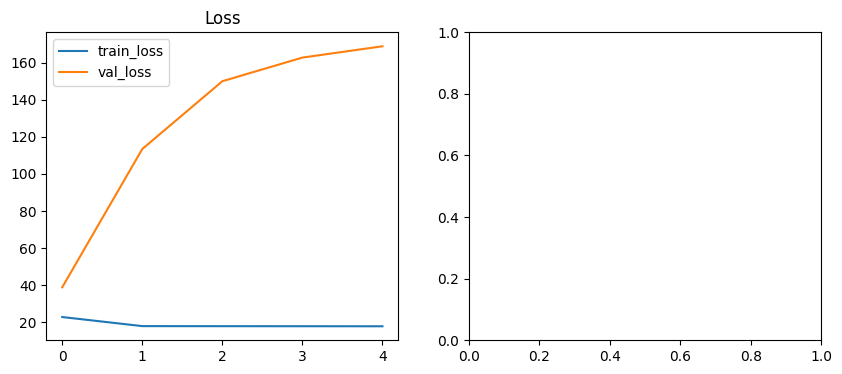

In [ ]:
# %%
# Cell 7: Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)

In [ ]:
# character-level accuracy approximate: average of the head accuracies
train_accs = [history.history.get(f'char_{i}_accuracy', history.history.get('accuracy')) for i in range(CAPTCHA_LENGTH)]
val_accs = [history.history.get(f'val_char_{i}_accuracy', history.history.get('val_accuracy')) for i in range(CAPTCHA_LENGTH)]
# If the numeric keys are missing (older TF), we'll simply not plot per-head accuracies.

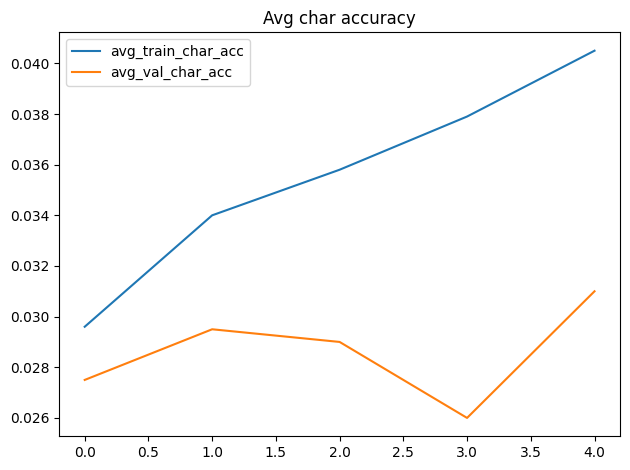

In [ ]:
try:
    avg_train_acc = np.mean([history.history[f'char_{i}_accuracy'] for i in range(CAPTCHA_LENGTH)], axis=0)
    avg_val_acc = np.mean([history.history[f'val_char_{i}_accuracy'] for i in range(CAPTCHA_LENGTH)], axis=0)
    plt.plot(avg_train_acc, label='avg_train_char_acc')
    plt.plot(avg_val_acc, label='avg_val_char_acc')
    plt.title('Avg char accuracy')
    plt.legend()
except KeyError:
    plt.text(0.1, 0.5, 'Per-head accuracy keys not found in history.\nCheck TF version.', fontsize=10)

plt.tight_layout()

In [ ]:
# %%
# Cell 8: Evaluate — character-level accuracy and full-string accuracy on validation set

# Predict on validation set
preds = model.predict(X_val)
# preds is a list of length CAPTCHA_LENGTH, each shape (N, num_classes)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step


In [ ]:
N = X_val.shape[0]
pred_chars = np.zeros((N, CAPTCHA_LENGTH), dtype=str)
for i in range(CAPTCHA_LENGTH):
    pred_idx = np.argmax(preds[i], axis=1)
    pred_chars[:, i] = [idx_to_char[idx] for idx in pred_idx]

# Build strings
pred_texts = [''.join(pred_chars[i]) for i in range(N)]
true_texts = [''.join(y_val[i]) for i in range(N)]

In [ ]:
# Character-level accuracy
char_correct = 0
for i in range(N):
    for p in range(CAPTCHA_LENGTH):
        if pred_chars[i,p] == y_val[i,p]:
            char_correct += 1
char_acc = char_correct / (N * CAPTCHA_LENGTH)

In [ ]:
# Full-string accuracy
full_correct = sum(1 for i in range(N) if pred_texts[i] == true_texts[i])
full_acc = full_correct / N

print(f'Validation character-level accuracy: {char_acc:.4f}')
print(f'Validation full CAPTCHA accuracy: {full_acc:.4f}')

Validation character-level accuracy: 0.0275
Validation full CAPTCHA accuracy: 0.0000


In [ ]:
# Show some examples of predictions
print('\nSome validation examples (true -> pred):')
for i in range(10):
    print(true_texts[i], '->', pred_texts[i])


Some validation examples (true -> pred):
zylm2 -> p0mvx
jy911 -> p0mvx
infau -> p0mvx
y01rt -> p0mvx
juoqj -> p0mvx
1rpff -> p0mvx
4fwzd -> 80mvx
6f28l -> 8ymvx
8qvsk -> pymvx
z0pt2 -> p0mvx


In [ ]:
# %%
# Cell 9: Save the final model (already best saved by checkpoint) and provide predict function

model.save('captcha_cnn_final.h5')

In [ ]:
def predict_captcha_from_image_array(img_array):
    # img_array: HxW (grayscale) or HxWx1 normalized [0,1]
    a = img_array.copy()
    if a.ndim == 2:
        a = np.expand_dims(a, axis=-1)
    a = a.reshape(1, IMG_H, IMG_W, 1)
    ps = model.predict(a)
    chars = [idx_to_char[np.argmax(p)] for p in ps]
    return ''.join(chars)

In [ ]:
# Quick test on a newly generated sample
s = random_captcha_text()
img = generate_captcha_image(s).astype(np.float32)/255.0
pred = predict_captcha_from_image_array(img)
print('\nRandom sample test:')
print('True:', s)
print('Pred :', pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Random sample test:
True: 6mbae
Pred : p0mvx


In [ ]:
# %%
# Cell 10: Tips & extension ideas for the lab
print('''\nTips for lab:
- Increase TRAIN_SIZE and EPOCHS for better performance (needs more time/GPU).
- Try data augmentation (random lines, rotation, elastic transform) to make model robust.
- Try segmenting characters and training a single-character classifier.
- Use CRNN or sequence models (CTC loss) for variable-length CAPTCHAs.
- Discuss ethics: demonstrate this only for educational / defensive purposes.\n''')


Tips for lab:
- Increase TRAIN_SIZE and EPOCHS for better performance (needs more time/GPU).
- Try data augmentation (random lines, rotation, elastic transform) to make model robust.
- Try segmenting characters and training a single-character classifier.
- Use CRNN or sequence models (CTC loss) for variable-length CAPTCHAs.
- Discuss ethics: demonstrate this only for educational / defensive purposes.

